# Problem set 5: APIs, SQL, and supervised machine learning

**Total points (without extra credit)**: 56 


## Resources from class

### APIs
- [Lecture slides](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/10_qss20_w23_APIs.pdf)
- [Activity solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/06_apis_solutions.ipynb)
- [DataCamp chapter](https://app.datacamp.com/learn/courses/intermediate-importing-data-in-python)

### Supervised ML
- [Lecture slides](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/12_qss20_w23_supervisedML.pdf)
- [Intro activity solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/08_ML_intro_activity_solutions.ipynb)
- [Part II activity solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/08_ML_optimization_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn)

### SQL
- [Lecture slides](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/13_qss20_w23_SQL.pdf)
- [Example code](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/109_SQL_examplecode.ipynb)
- [Activity solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/09_SQL_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/introduction-to-sql)

# Prep work: obtain an API key for the US Census (the American Community Survey)

- Obtain a census API key from [this request page](https://api.census.gov/data/key_signup.html)
- Place it in [the same credentials yaml file on GitHub that contains the SQL database access information](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/09_db_cred.yaml) (password, host, etc.) 
    - Name the combined credentials file something appropriate (feel free to get creative)
    - Change the database name from `sentencing` to `math_gencompare`

## 0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## note: you may need to install these using !pip install
# !pip install census
# !pip install us
import census
from census import Census
import us
from us import states
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs (see link above), we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [2]:
base_query = ("https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data"
            "&subject={subject}"
            "&subscale={subscale}"
            "&grade={grade}"
            "&Year={year}"
            "&variable={var}"
            "&jurisdiction={jurisdiction}"
            "&stattype={stattype}"
           )
query = (base_query).format(subject = "mathematics",
                         subscale = "MRPCM",
                         grade = "8", 
                         year = "2015",
                         var = "GENDER", 
                         jurisdiction = "CA",
                         stattype = "MN:MN")

pd.DataFrame(requests.get(query).json()['result'])

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0


**The scores look to be around equal to each other with Females being ahead by 0.61 points**

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [3]:
# Construct query
multi_year_query = (base_query).format(subject = "mathematics",
                         subscale = "MRPCM",
                         grade = "8", 
                         year = "2013,2015,2017,2019",
                         var = "GENDER", 
                         jurisdiction = "CA",
                         stattype = "MN:MN")

math_scores = pd.DataFrame(requests.get(multi_year_query).json()['result'])
math_scores

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.721824,1,0


## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis at 270 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

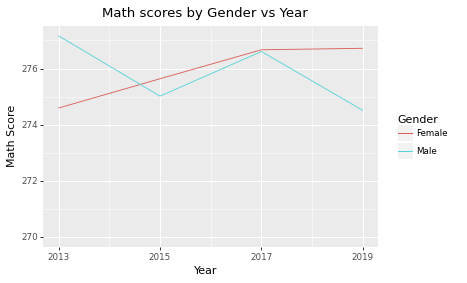

<ggplot: (8785537372157)>

In [4]:
# Plot
(
    ggplot(math_scores, aes(x='year', y='value', color='varValueLabel', group = "varValueLabel"))
    + geom_line() # line plot
    + scale_x_continuous(breaks=(2013, 2015, 2017, 2019))
    + ylim(270, None)
    + labs(title="Math scores by Gender vs Year", x='Year', y='Math Score', color = "Gender")
)

## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [5]:
# Construct query function
def construct_naep_query(year, place):
    return (base_query).format(subject = "mathematics",
                         subscale = "MRPCM",
                         grade = "8", 
                         year = ",".join(year),
                         var = "GENDER", 
                         jurisdiction = place,
                         stattype = "MN:MN")

In [6]:
# assert it's the same query
assert query == construct_naep_query(["2015"], "CA")
assert multi_year_query == construct_naep_query(["2013", "2015", "2017", "2019"], "CA")

## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see [API part 1 solutions code](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/08_apis_partI_solutions.ipynb) for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [7]:
# Processing the query
def process_naep_query(query):
    try:
        return pd.DataFrame(requests.get(query).json()['result'])
    except:
        return "Data not found; check your query"

In [8]:
# Execute on the 2013-2019 data
process_naep_query(construct_naep_query(["2013", "2015", "2017", "2019"], "CA"))

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.721824,1,0


In [9]:
# Call on a state that doesn't exist
process_naep_query(construct_naep_query(["2013", "2015", "2017", "2019"], "ZZ"))

'Data not found; check your query'

# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Load a credentials file that contains the credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

Note: to establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect `VPN`  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/?CategoryID=17668))

In [10]:
creds = load_creds("db_cred.yaml")

In [11]:
cnx = mysql.connector.connect(user=creds['math_gencompare']['user'], 
                            password=creds['math_gencompare']['password'],
                            port=creds['math_gencompare']['port'],
                            database= creds['math_gencompare']['database'],
                            host = creds['math_gencompare']['host'])
cnx

## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [12]:
# Reading in the results as a dataframe
query = "SELECT * FROM math_gencompare LIMIT 5"

res = pd.read_sql_query(query, cnx)
res

,abbrev,FIPS,state,year,female,male,is_early_vote
0,AK,2,Alaska,2013,281.388243030547,281.723376175464,None
1,AL,1,Alabama,2013,268.920111754346,269.457455785562,None
2,AR,5,Arkansas,2013,278.381788404903,277.457662328569,None
3,AZ,4,Arizona,2013,279.249581150207,280.174388600923,None
4,CA,6,California,2013,274.597823860242,277.167170641967,None


## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [13]:
# Printing out stats
total_rows = pd.read_sql_query("SELECT COUNT(*) as count FROM math_gencompare", cnx)
distinct_states = pd.read_sql_query("SELECT COUNT(DISTINCT state) as count FROM math_gencompare", cnx)
distinct_years = pd.read_sql_query("SELECT COUNT(DISTINCT year) as count FROM math_gencompare", cnx)
print("Number of Rows: " + str(total_rows.loc[0,"count"]))
print("Number of distinct states: " + str(distinct_states.loc[0,"count"]))
print("Number of distinct years: " + str(distinct_years.loc[0,"count"]))

Number of Rows: 200
Number of distinct states: 50
Number of distinct years: 4


**The data seems to be in long format where each state and year are repeated. Since there are 200 rows, each state is probably repeated 4 times for each of the 4 years (50*4 = 200).**

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [14]:
# Constructing is_male_higher
is_male_higher_q = """
SELECT *,
CASE 
    WHEN female < male THEN 1
    ELSE 0
END as is_male_higher
FROM math_gencompare
"""
is_male_higher_d = pd.read_sql_query(is_male_higher_q, cnx)
is_male_higher_d.head()

mean = is_male_higher_d["is_male_higher"].mean()
print(str(mean) + " is the porportion of state-years where male students have higher scores.")

,abbrev,FIPS,state,year,female,male,is_early_vote,is_male_higher
0,AK,2,Alaska,2013,281.388243030547,281.723376175464,None,1
1,AL,1,Alabama,2013,268.920111754346,269.457455785562,None,1
2,AR,5,Arkansas,2013,278.381788404903,277.457662328569,None,0
3,AZ,4,Arizona,2013,279.249581150207,280.174388600923,None,1
4,CA,6,California,2013,274.597823860242,277.167170641967,None,1


0.515 is the porportion of state-years where male students have higher scores.


## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [15]:
# contructing percent of states
percent_states_q = """
SELECT tmp.year, avg(tmp.is_male_higher) as percentage
FROM(
    SELECT *,
    CASE 
        WHEN female < male THEN 1
        ELSE 0
    END as is_male_higher
    FROM math_gencompare
) tmp
GROUP BY year
"""
percent_states_d = pd.read_sql_query(percent_states_q, cnx)
percent_states_d.head()

,year,percentage
0,2013,0.62
1,2015,0.56
2,2017,0.58
3,2019,0.30


**B. Over the past 4 years, the number of states where males out score females has been decreasing. In 2013, 62% of states have males outscoring females and in 2019 it was only 30%.**

## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

In [16]:
# Percent of years
percent_year_q = """
SELECT tmp.state, avg(tmp.is_male_higher) as percentage
FROM(
    SELECT *,
    CASE 
        WHEN female < male THEN 1
        ELSE 0
    END as is_male_higher
    FROM math_gencompare
) tmp
GROUP BY state
ORDER BY percentage desc
"""
percent_year_d = pd.read_sql_query(percent_year_q, cnx)

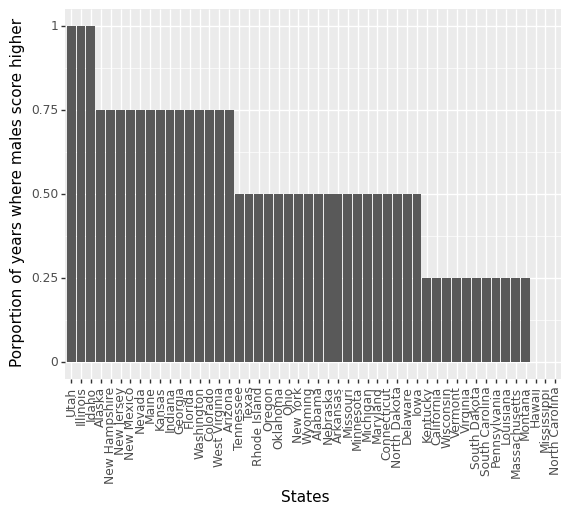

<ggplot: (8785537922024)>

In [17]:
(ggplot(percent_year_d, aes(x = 'state', y = 'percentage')) +
geom_bar(stat = "identity", position = "dodge") +
ylab("Porportion of years where males score higher")+
xlab("States") + 
theme(axis_text_x = element_text(angle = 90, hjust = 0.3))+
scale_x_discrete(limits = percent_year_d["state"])
)

## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_vote` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_vote` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [18]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]


In [19]:
## query to get is_early_vote_state
early_vote_q = """
SELECT tmp.is_early_vote_state, tmp.year, avg(tmp.is_male_higher) as percentage
FROM(
    SELECT *,
    CASE 
        WHEN state in ({states})  THEN 1
        ELSE 0
    END as is_early_vote_state,
    CASE 
        WHEN female < male THEN 1
        ELSE 0
    END as is_male_higher
    FROM math_gencompare
) tmp
GROUP BY tmp.is_early_vote_state, tmp.year
""".format(states = ", ".join(f'"{s}"' for s in list_suffrage))
early_vote_d = pd.read_sql_query(early_vote_q, cnx)
early_vote_d

,is_early_vote_state,year,percentage
0,0,2013,0.5909
1,1,2013,0.8333
2,0,2015,0.5455
3,1,2015,0.6667
4,0,2017,0.5455
5,1,2017,0.8333
6,0,2019,0.2727
7,1,2019,0.5000


**C. It seems like the expansion of voting is not correlated with girls scoring better on math tests a centaur later. In the above dataframe, early voting states consistently still have a higher percentage of states where males score higher than women, showing that the expansion of voting has little impact on increasing math test scores for girls.**

# 3. Pull state-level attributes using Census API (8 points)

You want to explain the variation you see across states in gender gaps in test scores by looking at demographics of the state population. To do so, we'll pull demographics from the American Community Survey (ACS), a US Census data product discussed more here: https://en.wikipedia.org/wiki/American_Community_Survey

## 3.1 Initialize Census API connection using API key (0 points)

- Load the credentials yaml file with the Census API key
- Initialize the Census API connection using API key and the `census` package
    - Documentation here for the `census` package on establishing an API connection: https://github.com/datamade/census

In [20]:
# loading credentials
census_creds = load_creds("census_cred.yaml")
c = Census(census_creds["census"]["api_key"])

## 3.2 Run this function (feeding it your api connection) to get a list of variables to pull (0 points)

Feed the connection to the API you created in previous step (if you print type it's a census.core.Census class) to the `your_connection` argument in the function)

In [21]:
## keep in blank
to_pull = ['RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS',
          'ALLOCATION OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS - PERCENT OF INCOME ALLOCATED',
          'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)',
          'EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER',
          'HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP']

In [22]:
## keep in blank
def get_acs_varnames(your_connection):
    
    ## get tables for the acs 5-year estimates
    all_tables = pd.DataFrame(your_connection.acs5.tables(year = 2018))
    
    ## specify the ones to pull
    info_topull = all_tables[all_tables.description.isin(to_pull)].copy()
    
    ## use raw api to get varnames within those tables
    all_vars = [pd.DataFrame(requests.get(one_table).json()['variables']).T
                for one_table in info_topull.variables]
    all_vars_df = pd.concat(all_vars)
    all_vars_df['varname'] = all_vars_df.index
    
    ## subset to relevant
    all_vars_df_subset = all_vars_df[['varname', 'group', 'label',
                                    'concept']].copy()
    all_vars_df_est = all_vars_df_subset[all_vars_df.varname.str.contains("E$", 
                                        regex = True)].copy()
    return(all_vars_df_est)
    

In [23]:
## NOTE: replace the your_connection with your 
## connection to the Census API
acs_cols = get_acs_varnames(c)
acs_cols.head()

,varname,group,label,concept
B17026_003E,B17026_003E,B17026,Estimate!!Total!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_004E,B17026_004E,B17026,Estimate!!Total!!.75 to .99,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_001E,B17026_001E,B17026,Estimate!!Total,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_002E,B17026_002E,B17026,Estimate!!Total!!Under .50,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_007E,B17026_007E,B17026,Estimate!!Total!!1.50 to 1.74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS


## 3.3 Pull the variables for all 50 states (8 points)

**A.** Use list comprehension to pull these variables for every state (each FIPS code) using the `acs5.state` method for the year 2013.
- **Hint 1:** See the documentation for how to feed it variables to pull (requires a tuple); the documentation shows an example state--`MD`. You can find the other `FIPS` Ccodes for states in the `states` object in `us` package you loaded above): https://github.com/datamade/census/blob/70e2c08710c1e10e5bc2054b78613fa8794d4765/README.rst
- **Hint 2:** You can feed the tuple of ACS variable names to the function you'll use to pull Census/ACS data; you should NOT need to iterate over individual vars when pulling.
- **Note**: this takes ~1-2 minutes to run on our machine

**B.** Transform the result (which is a list of json) into a list of dataframes. Then concatenate and melt (on state) into one dataframe

**C.** Merge with the `all_states_fips` df, then merge that with `acs_cols` from 3.2 (on varname and variable) to know both which states the variables correspond to and the more informative variable names 

Call the final output `acs_df_forperc` so you can run the next code we provide

In [24]:
## run this code- keep in blank
## NOTE: you need to have the us package
## installed and imported
cols_pull = tuple(acs_cols.varname) # tuple form of the acs variable names to pull
all_states = states.STATES
all_states_fips = pd.DataFrame({'FIPS':
                    [one_state.fips for one_state in all_states],
                    'state': [one_state.name for one_state in all_states],
                'abbrev': [one_state.abbr for one_state in all_states]})
all_states_fips.head()

,FIPS,state,abbrev
0,01,Alabama,AL
1,02,Alaska,AK
2,04,Arizona,AZ
3,05,Arkansas,AR
4,06,California,CA


In [25]:
# concat and melt
list_of_df = [pd.DataFrame(c.acs5.state(cols_pull, fips, year=2013)) for fips in all_states_fips.FIPS]
joined_df = pd.concat(list_of_df, ignore_index=True)
joined_df = pd.melt(joined_df, id_vars = "state").rename(columns = {"state":"FIPS"})
joined_df.head()

,FIPS,variable,value
0,01,B17026_003E,50074
1,02,B17026_003E,3056
2,04,B17026_003E,55487
3,05,B17026_003E,31249
4,06,B17026_003E,292341


In [26]:
merged = joined_df.merge(all_states_fips, on = "FIPS")
acs_df_forperc = merged.merge(acs_cols, right_on = "varname", left_on = "variable")
acs_df_forperc.head()

,FIPS,variable,value,state,abbrev,varname,group,label,concept
0,01,B17026_003E,50074,Alabama,AL,B17026_003E,B17026,Estimate!!Total!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
1,02,B17026_003E,3056,Alaska,AK,B17026_003E,B17026,Estimate!!Total!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
2,04,B17026_003E,55487,Arizona,AZ,B17026_003E,B17026,Estimate!!Total!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
3,05,B17026_003E,31249,Arkansas,AR,B17026_003E,B17026,Estimate!!Total!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
4,06,B17026_003E,292341,California,CA,B17026_003E,B17026,Estimate!!Total!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS


## 3.4 run code to transform counts into percentages (0 points)

- Run the following code to transform the ACS counts in `acs_df_forperc` into percentages

Note: You may see a warning from the str.split step; feel free to ignore it


In [27]:
def create_percentages(df, name_estimatecol = 'estimate'):
    
    ## remove cols that dont need percentages
    df_forperc = df[~df.perc_NA].copy()
    
    ## sort by 
    
    ## group by location and variable prefix 
    group_co_tract_varg = df_forperc.groupby(['FIPS', 'variable_prefix'])
    
    ## iterate over groups
    df_longperc = []
    for group, data_raw in group_co_tract_varg:
        prefix = data_raw.variable_prefix.iloc[0]
        FIPS = data_raw.FIPS.iloc[0]
        row_list_group = []
        data = data_raw.sort_values(by = 'variable_suffix')
        for i in range(1, data.shape[0]):
            numerator = data[name_estimatecol].iloc[i]
            denominator = float(data[name_estimatecol].iloc[0])
            if denominator == 0:
                denominator = np.nan
            if denominator != 0:
                percentage = numerator / denominator
                row = [prefix, FIPS]
                row = row + [data.variable_suffix.iloc[i], percentage]
                row_list_group.append(row)
        df_longperc.append(pd.DataFrame(row_list_group))
    percentages_all_groups = pd.concat(df_longperc)
    percentages_all_groups.columns = ['variable_prefix',"FIPS",
                                  'variable_suffix', 'percentage']
    percentages_all_groups['percentage'] = percentages_all_groups.percentage.astype(float)
    return(percentages_all_groups)



In [28]:
varnames_percnotrelevant = ["B19013_001E"]

## create prefix and suffix columns
acs_df_forperc['variable_prefix'], acs_df_forperc['variable_suffix'] = \
                                acs_df_forperc['varname'].str.split('_', 1).str
acs_df_forperc['perc_NA'] = np.where(acs_df_forperc.varname.isin(varnames_percnotrelevant),
                                  True, False)
acs_df_forperc = acs_df_forperc[acs_df_forperc.varname != "GEO_ID"].copy()

perc_long = create_percentages(acs_df_forperc, 'value').sort_values(by = 'variable_prefix')

<ipython-input-28-b4b5ca7a8bf5>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


In [29]:
perc_long_wnames = pd.merge(perc_long,
                           acs_df_forperc,
                           on = ['variable_prefix', 'variable_suffix', 'FIPS'],
                           how = "right")
perc_long_wnames['value'] = perc_long_wnames.value.astype(float)

perc_long_wnames['percentage'] = np.where(perc_long_wnames.perc_NA,
                                         perc_long_wnames.value,
                                         perc_long_wnames.percentage)
perc_long_wnames['varname_words'] = "acspredict_" + perc_long_wnames.concept.str.replace("\s+|\(|\)", "_", 
                                    regex = True).str.lower() + \
                            perc_long_wnames.label.str.replace("\.|\!|\,|\(|\)|\-", 
                                    "", regex = True).str.lower() 

perc_long_wnames_final = perc_long_wnames[['FIPS', 'percentage', 
                                          'varname_words']].copy()


perc_wide = pd.pivot_table(perc_long_wnames_final, 
                           index = 'FIPS',
                          columns='varname_words',
                            values='percentage').reset_index()

## merge state info back on
perc_wide_wstate = pd.merge(perc_wide,
                           all_states_fips,
                           on = "FIPS",
                           how = "left")


In [30]:
perc_wide_wstate.head()

,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin households,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family households,acspre

## 3.5 extra credit (2 points)

Use list comprehension and NAEP query creation/process results functions you created above to iterate over state abbreviations in `all_states_fips` and pull the same test score gap information

If skipping, you'll read in pkl at next step

**Note**: this took 2 mins to run on my machine

In [31]:
# query all data
NAEP_df_list = [process_naep_query(construct_naep_query(["2013"], abbrev))
                for abbrev in all_states_fips["abbrev"]]
acs_wmath = pd.concat(NAEP_df_list, ignore_index=True)
acs_wmath.head()

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,AL,GENDER,Gender,1,Male,269.457456,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,AL,GENDER,Gender,2,Female,268.920112,1,0
2,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,AK,GENDER,Gender,1,Male,281.723376,1,0
3,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,AK,GENDER,Gender,2,Female,281.388243,1,0
4,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,AZ,GENDER,Gender,1,Male,280.174389,1,0


# 4. Explore variation in math score disparities and trends (18 points)

## 4.0 Read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [32]:
## Used extra credit dataframe

## 4.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


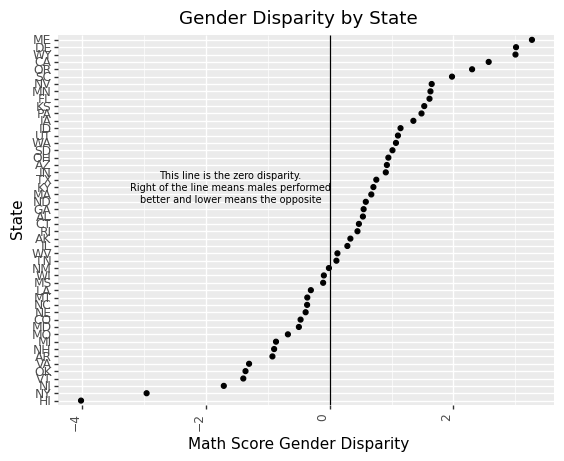

<ggplot: (8785538516977)>

In [33]:
## creating visualization
disparity_df = acs_wmath[["jurisdiction", "varValueLabel", "value"]]
disparity_df = disparity_df.pivot(index='jurisdiction', columns='varValueLabel', values='value').reset_index()
disparity_df["disparity"] = disparity_df["Male"] - disparity_df["Female"]
disparity_df = disparity_df.sort_values("disparity")
(
    ggplot(disparity_df, aes(x='jurisdiction', y='disparity'))
    + geom_point(stat = "identity")
    + labs(title = "Gender Disparity by State", x='State', y='Math Score Gender Disparity')
    + geom_hline(yintercept = 0)
    + annotate("text", x = 30, y = -1.6, size = 7,  label = 'This line is the zero disparity.\nRight of the line means males performed\nbetter and lower means the opposite')
    + theme(axis_text_x = element_text(angle = 90, hjust = 1))
    + scale_x_discrete(limits = disparity_df["jurisdiction"])
    + coord_flip()
)

## 4.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a smoothed scatterplot of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations - in states with higher median household income (MHI), do 
   - boys tend to perform better than boys in states with lower MHI?
   - girls tend to perform better than girls in states with lower MHI?
   - boys tend to outperform girls more than they do in states with lower MHI?

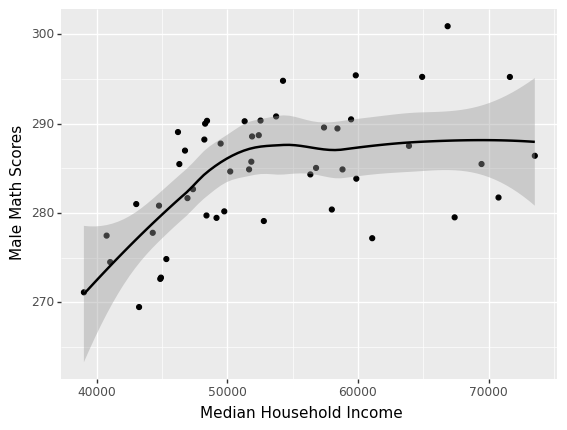

<ggplot: (8785532030973)>

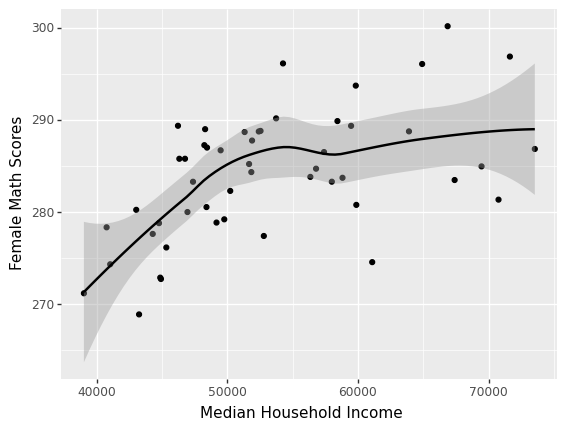

<ggplot: (8785537639156)>

In [34]:
# plotting
median_house_income = "acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"
disparity_df["indicator"] = np.where(disparity_df["Male"] > disparity_df["Female"], 1, 0)
both = perc_wide_wstate.merge(disparity_df, left_on = "abbrev", right_on = "jurisdiction")
(
    ggplot(both, aes(x=median_house_income, y='Male'))
    + geom_point()
    + labs(x='Median Household Income', y='Male Math Scores')
    + geom_smooth()
)
(
    ggplot(both, aes(x=median_house_income, y='Female'))
    + geom_point()
    + labs(x='Median Household Income', y='Female Math Scores')
    + geom_smooth()
)

In [35]:
np.corrcoef(both['Male'], both[median_house_income])
np.corrcoef(both['Female'], both[median_house_income])
np.corrcoef(both['indicator'], both[median_house_income])

array([[1.        , 0.50734719],
       [0.50734719, 1.        ]])

array([[1.        , 0.54337803],
       [0.54337803, 1.        ]])

array([[ 1.       , -0.0338752],
       [-0.0338752,  1.       ]])

**D. Interpreting the correlations**

**Boys from states with high MHI tend to out perform boys in states with lower MHI as shown by the positive correlation of ~0.5 between MHI and male test scores**

**Girls from states with high MHI tend to out perform girls in states with lower MHI as shown by the positive correlation of ~0.54 between MHI and female test scores**

**Boys tend to outperform girls less in states with higher MHI as shown by the negative correlation of ~-0.03 between MHI and the indicator**

## 4.3 Predicting disparities (10 points)

**A.** Read in the raw `acs_wmath` data again (this loses the variables you created above)

**B.** Construct a binary indicator variable for male score > female score  for each year - for full credit, do so without repeating the difference code for each of the four years: name these according to following convention: `outcome_male_higher_female_year` where year is 2013, 2015, 2017, or 2019 (e.g., 2013: `outcome_male_higher_female_2013`). After this, remove the raw math scores as columns in the data (so filter out any column with the word math)

**C.** Melt the data (`acs_wmath`) to long where instead of wide years, years are repeated within state; the ACS vars will also be repeated since we only pulled one year. In other words, reshape the data from "wide format", where each state is a row and we have separate columns for each year, to "long format", where states are repeated four times: once for each year in the data (2013, 2015, 2017, 2019)

**D.** Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test. 

**E.** Normalize the features to mean 0, variance 1 and estimate a decision tree with a max depth of 5. 

- **Hint:** The ML literature recommends using the training set scaler to transform the test set, rather than using a unique scaler to initialize each one. The reasons are discussed here: https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data

**F.** Interpret the feature importances

**G.** Evaluate the precision and recall of that model in the test set states without using the `score`, `precision`, or `recall` functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?

**Additional resources:** 

- Feature normalization: https://scikit-learn.org/stable/modules/preprocessing.html

- Definition of precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall

In [36]:
# A. load data
acs_wmath = pd.read_csv("acs_wmath.csv")
acs_wmath.head()

,math_female_2013,math_female_2015,math_female_2017,math_female_2019,math_male_2013,math_male_2015,math_male_2017,math_male_2019,abbrev,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetot

In [37]:
# B. construct binary indicators for male higher
years = ["2013", "2015", "2017", "2019"]
for year in years:
    acs_wmath["outcome_male_higher_female_" + year] = np.where(acs_wmath["math_male_" + year] >
                                                              acs_wmath["math_female_" + year], 1, 0)
acs_wmath = acs_wmath[[col for col in acs_wmath.columns if "math" not in col]]
acs_wmath[[col for col in acs_wmath.columns if "outcome_male_higher_female_" in col]].head()

,outcome_male_higher_female_2013,outcome_male_higher_female_2015,outcome_male_higher_female_2017,outcome_male_higher_female_2019
0,1,0,1,1
1,1,0,1,0
2,0,1,1,0
3,1,1,1,0
4,1,0,0,0


In [38]:
# C. your code here to melt data
acs_wmath_long = pd.melt(
    acs_wmath, 
    id_vars=[col for col in acs_wmath.columns if "outcome_male_higher_female_" not in col], 
    value_vars=[col for col in acs_wmath.columns if "outcome_male_higher_female_" in col], 
    var_name='year', 
    value_name='outcome_male_higher_female'
)
acs_wmath_long[["abbrev","year", "outcome_male_higher_female"]].head()

,abbrev,year,outcome_male_higher_female
0,AK,outcome_male_higher_female_2013,1
1,AL,outcome_male_higher_female_2013,1
2,AR,outcome_male_higher_female_2013,0
3,AZ,outcome_male_higher_female_2013,1
4,CA,outcome_male_higher_female_2013,1


In [39]:
# D. train/test split
random.seed(1)
def train_test_split(df):
    states = df["abbrev"].unique()
    for_train = random.sample(list(states), 35)
    train = df[df["abbrev"].isin(for_train)]
    test = df[~df["abbrev"].isin(for_train)]
    return train, test

train, test = train_test_split(acs_wmath_long)

In [40]:
[col for col in train.columns if len(col) < 30]

['abbrev', 'FIPS', 'state', 'year', 'outcome_male_higher_female']

In [41]:
# E. normalize features and fit model
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.drop(columns = ['abbrev', 'state', 'year', 'outcome_male_higher_female'], axis = 1))
test_scaled = scaler.transform(test.drop(columns = ['abbrev', 'state', 'year', 'outcome_male_higher_female'], axis = 1))

dt_classifier = DecisionTreeClassifier(max_depth=5) 
dt_classifier.fit(train_scaled, train["outcome_male_higher_female"])
predictions = dt_classifier.predict(test_scaled)

DecisionTreeClassifier(max_depth=5)

In [42]:
# F. interpret feature importances
feature_importances = dt_classifier.feature_importances_
f = []
i = []
for feature, importance in zip(train.drop(columns = ['abbrev', 'state', 'year', 'outcome_male_higher_female'], axis = 1), feature_importances):
    if importance > 0:
        f.append(feature)
        i.append(importance)
pd.DataFrame({"feature": f, "importance": i}).sort_values("importance", ascending = False)

,feature,importance
4,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin households,0.383664
6,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdschildadopted child,0.125890
5,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family households,0.111465
0,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,0.109818
8,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdssoninlaw or daughterinlaw,0.083599
7,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsnonrelativesunmarried partner,0.056295
3,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,0.049850
9,acspredict_ratio_of_income_to_poverty_level_of_families_in_the_past_12_monthsestimatetotal75 to 99,0.037619
1,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,0.020900
2,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,0.020900


**Above are all the features with non 0 importance. It is ranked by most important to least important.**

In [43]:
# G. your code here to evaluate model
def get_scores(actual, pred):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(actual)):
        if actual[i] == pred[i]:
            if pred[i] == 1:
                tp += 1
            else:
                tn += 1
        else:
            if pred[i] == 1:
                fp += 1
            else:
                fn += 1
    return tp, tn, fp, fn

tp, tn, fp, fn = get_scores(list(test["outcome_male_higher_female"]), predictions)
accuracy = (tp + tn) /(tp+tn+fp+fn)
precision = tp /(tp+fp)
recall = tp /(tp+fn)
print("The accuracy for this model is: " + str(accuracy))
print("The precision for this model is: " + str(precision))
print("The recall for this model is: " + str(recall))

The accuracy for this model is: 0.55
The precision for this model is: 0.7
The recall for this model is: 0.4


**This model is performing worse compared to our class example probably because of the number of observations. Since our current model only has 100 observations, there is less data to effectively train the featurese and it only takes a couple of outliers to throw the model off. Thus, increasing the number of observations would most likely improve our model**